In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import random

In [9]:
def clean_column_names(df):
    df.columns = [re.sub(r'[^\w\s]', '_', col) for col in df.columns]
    df.columns = ['feature_'+col if col[0].isdigit() else col for col in df.columns]
    df.columns = [col.strip('_') for col in df.columns]
    return df

def prepare_features(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    for col in ['Holiday', 'Vendor']:
        df[col] = df[col].astype('category').cat.codes

    targets = ['RBused', 'RB_800', 'RB_1800', 'RB_2100', 'RB_2600_10', 'RB_2600_20']
    for target in targets:
        df[f'{target}_lag_1h'] = df.groupby(['enb_id', 'pci'])[target].shift(1)
        df[f'{target}_lag_24h'] = df.groupby(['enb_id', 'pci'])[target].shift(24)
        df[f'{target}_lag_168h'] = df.groupby(['enb_id', 'pci'])[target].shift(168)

    for target in targets:
        rolling = df.groupby(['enb_id', 'pci'])[target].rolling(window=24)
        df[f'{target}_rolling_mean_24h'] = rolling.mean().reset_index(level=[0,1], drop=True)
        df[f'{target}_rolling_std_24h'] = rolling.std().reset_index(level=[0,1], drop=True)

    df['User_RB_ratio'] = df['Usertotal'] / df['RBtotal']

    df['timestamp_int'] = df['timestamp'].astype(int) // 10**9

    df = clean_column_names(df)

    return df

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return rmse, mae, r2

def train_lightgbm_model(X, y, tscv):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1
    }

    train_data = lgb.Dataset(X, label=y)
    initial_model = lgb.train(params, train_data, num_boost_round=100)
    feature_importance = initial_model.feature_importance()
    top_features = X.columns[np.argsort(feature_importance)[-20:]].tolist()
    X = X[top_features]

    models = []
    scores = []

    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)

        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[early_stopping_callback]
        )

        y_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        models.append(model)
        scores.append(score)

    best_model = models[np.argmin(scores)]
    return best_model, np.mean(scores), top_features

def plot_actual_vs_predicted(model, X, y, target):
    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {target}')
    plt.show()

def predict_for_enbid_pci(model, df, enbid_pci, target, feature_columns):
    specific_data = df[df['enbid_pci'] == enbid_pci]

    if specific_data.empty:
        print(f"No data found for enbid_pci {enbid_pci}")
        return None, None

    X = specific_data[feature_columns]
    predictions = model.predict(X)

    return specific_data['timestamp'], predictions

def plot_actual_vs_predicted_timeseries(df, model, enbid_pci, target, feature_columns):
    timestamps, predictions = predict_for_enbid_pci(model, df, enbid_pci, target, feature_columns)

    if timestamps is None or predictions is None:
        return

    actual_values = df[df['enbid_pci'] == enbid_pci][target]

    plt.figure(figsize=(20, 5))
    plt.plot(timestamps, actual_values, label='Actual', alpha=0.7)
    plt.plot(timestamps, predictions, label='Predicted', alpha=0.7)
    plt.legend()
    plt.title(f'Actual vs Predicted {target} for enbid_pci {enbid_pci}')
    plt.xlabel('Timestamp')
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# 메인 실행 코드
file_path = '/content/drive/MyDrive/Colab_Notebooks/Data2/ELG_Busan_PoC_per_CA_site_0226_0519.csv'
df = pd.read_csv(file_path)
df = prepare_features(df)

df = df.dropna()

Training model for RBused...
RBused model average RMSE: 6.697057476685579
RMSE: 6.3210, MAE: 3.8181, R^2: 0.8799


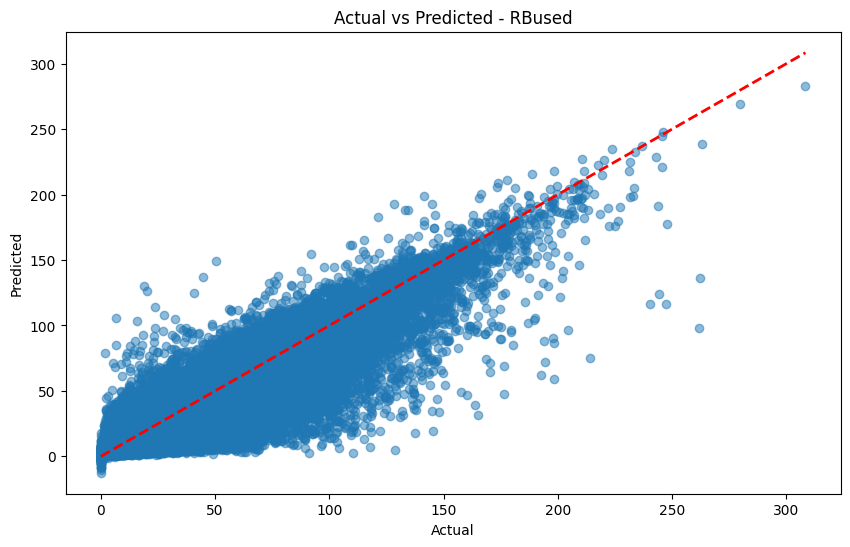

Training model for RB_800...
RB_800 model average RMSE: 2.8739918542329446
RMSE: 2.7962, MAE: 1.5528, R^2: 0.7537


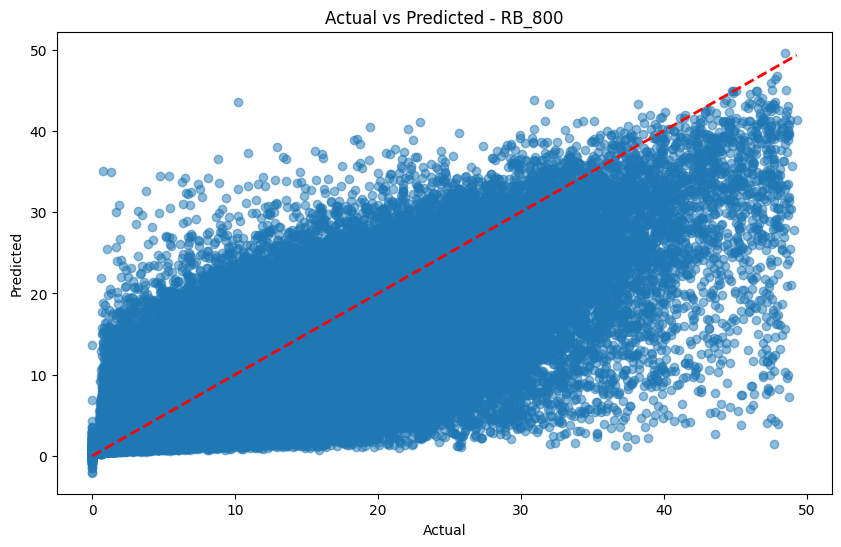

Training model for RB_1800...
RB_1800 model average RMSE: 3.817929707211148
RMSE: 3.6352, MAE: 2.0494, R^2: 0.8010


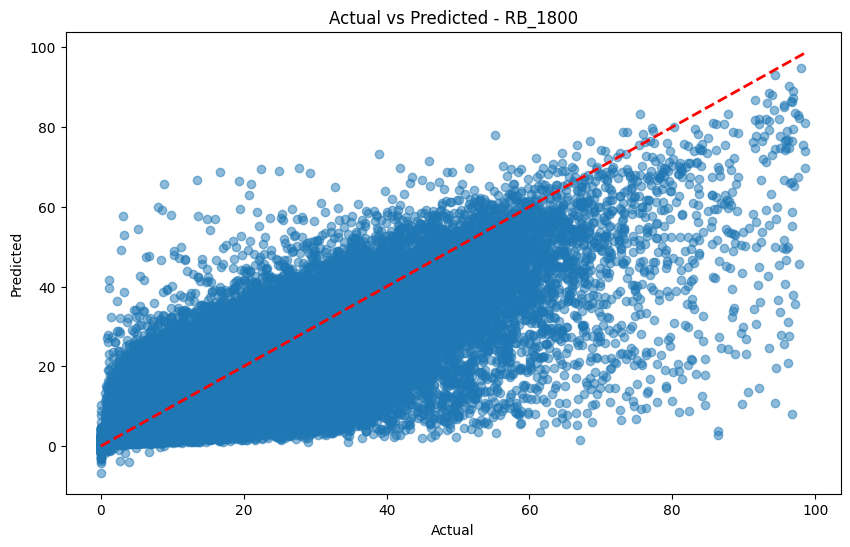

Training model for RB_2100...
RB_2100 model average RMSE: 1.3385138681719004
RMSE: 1.2613, MAE: 0.5479, R^2: 0.8380


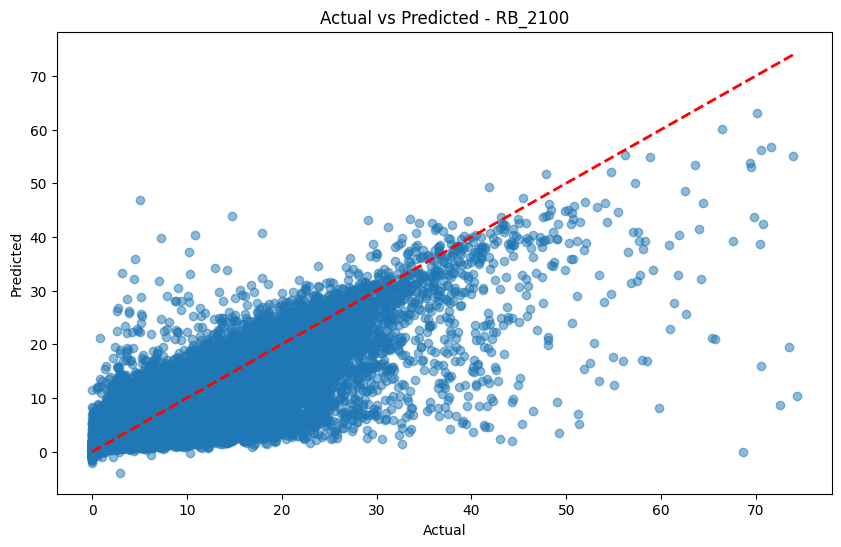

Training model for RB_2600_10...
RB_2600_10 model average RMSE: 0.39953398739586227
RMSE: 0.3601, MAE: 0.1076, R^2: 0.8883


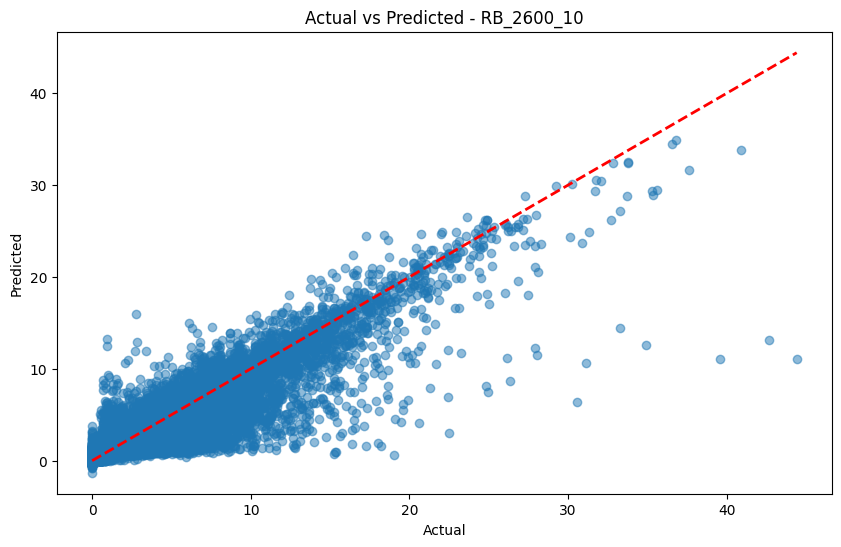

Training model for RB_2600_20...
RB_2600_20 model average RMSE: 1.7803643046059605
RMSE: 1.5620, MAE: 0.6344, R^2: 0.9407


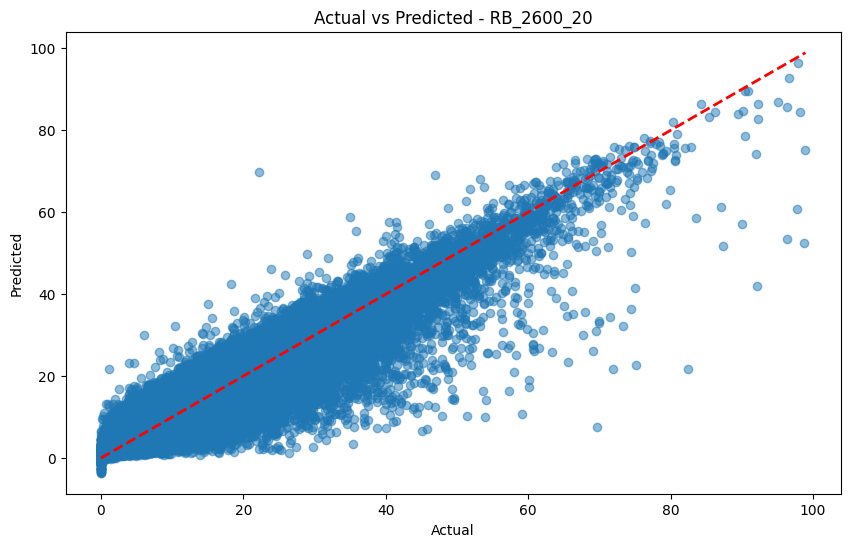

Training and evaluation complete!


In [12]:
targets = ['RBused', 'RB_800', 'RB_1800', 'RB_2100', 'RB_2600_10', 'RB_2600_20']

feature_columns = [col for col in df.columns if col not in targets and df[col].dtype in ['int64', 'float64', 'bool']]

tscv = TimeSeriesSplit(n_splits=3)

sample_size = int(len(df) * 0.2)
df_sampled = df.sample(n=sample_size, random_state=42)

models = {}
for target in targets:
    print(f"Training model for {target}...")
    X = df_sampled[feature_columns]
    y = df_sampled[target]
    model, score, top_features = train_lightgbm_model(X, y, tscv)
    models[target] = (model, top_features)
    print(f"{target} model average RMSE: {score}")

    # 모델 평가
    rmse, mae, r2 = evaluate_model(model, X[top_features], y)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

    # 실제 값과 예측 값 비교 시각화
    plot_actual_vs_predicted(model, X[top_features], y, target)

print("Training and evaluation complete!")

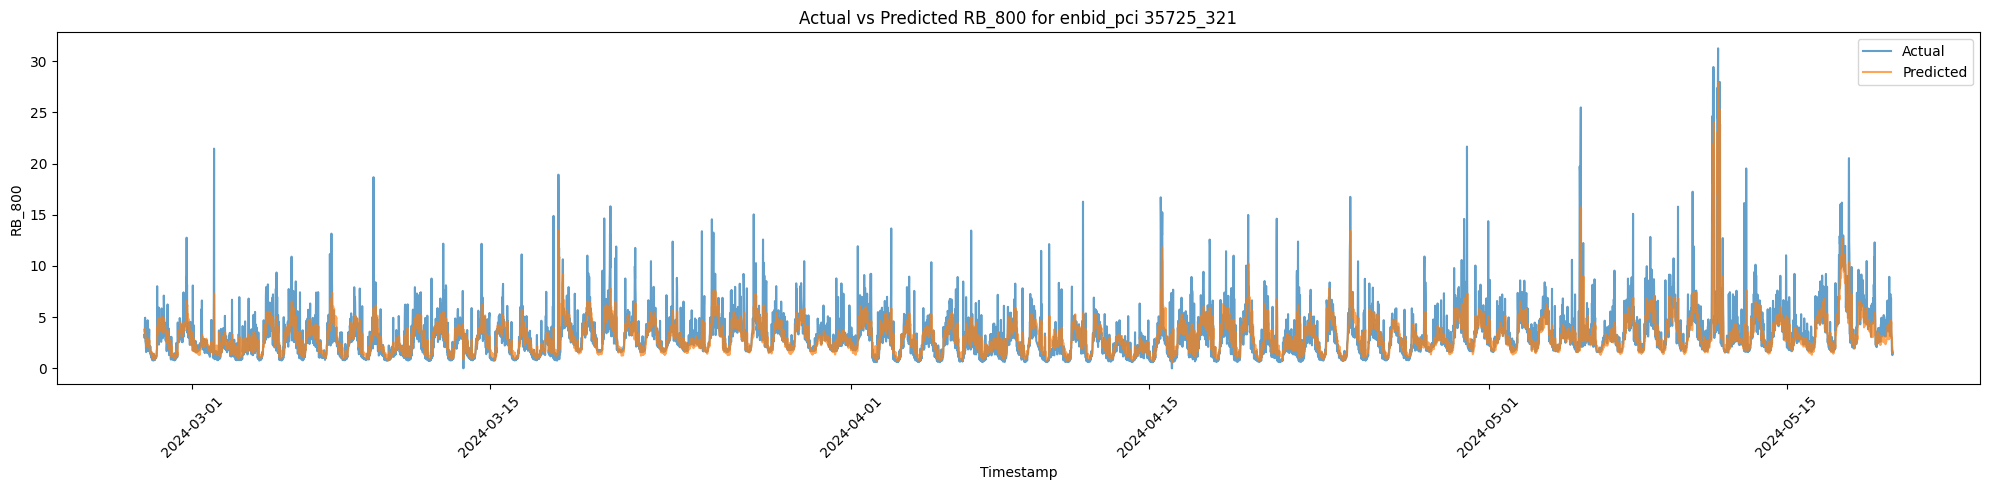

Visualization complete for enbid_pci 35725_321


In [15]:
# RB_800에 대한 시계열 예측 시각화
target = 'RB_800'
model, top_features = models[target]
plot_actual_vs_predicted_timeseries(df, model, random_enbid_pci, target, top_features)

print(f"Visualization complete for enbid_pci {random_enbid_pci}")